Array Operations with Julia
----------------

In languages such as Python, libraries like Numpy are used to handle computationaly intesive matrix operations. Numpy can increase execution speed many-times over.

In Julia, this is not the case. Computationaly intesive matrix operations can be performed natively within Julia. 

As a simple example, consider the following equation:

$$u^{n+1}_i = u^n_i-u^n_{i-1}$$

Now, given a vector $u^n = [0, 1, 2, 3, 4, 5]\ \ $   we can calculate the values of $u^{n+1}$ by iterating over the values of $u^n$ with a for loop.  

In [1]:
u = [0, 1, 2, 3, 4, 5]

for i in 2:length(u)
    println(u[i] - u[i-1])
end

1
1
1
1
1


This is the expected result and the execution time was nearly instantaneous.  If we perform the same operation as an array operation, then rather than calculate $u^n_i-u^n_{i-1}\ $ 5 separate times, we can slice the $u$ array and calculate each operation with one command:

In [2]:
u[2:end] - u[1:end-1]

5-element Array{Int64,1}:
 1
 1
 1
 1
 1

What this command says is subtract the 1st, 2nd, 3rd, 4th and 5th elements of $u$ from the 2nd, 3rd, 4th, 5th and 6th elements of $u$.

### Speed Differences

For a 6 element array, the differences between the for loop and array operation are pretty slim. There will be no appreciable difference in execution time because there are so few operations taking place. But if we revisit 2D linear convection, we can see some substantial speed differences.


In [3]:
nx = 81
ny = 81
nt = 100

c = 1.0

dx = 2.0 / (nx - 1)
dy = 2.0 / (ny - 1)

sigma = 0.2

dt = sigma * dx

x = range(0.0, stop=2.0, length=nx)
y = range(0.0, stop=2.0, length=ny)

u = ones(ny, nx);
uₙ = ones(ny, nx); 

u[ 0.5 .≤ y .≤ 1 , 0.5 .≤ x .≤ 1] .= 2.0;

With our initial conditions all set up, let's first try running our original nested loop code, making use of BenchmarkTools.jl, which will help us evaluate the performance of our code. 

**Note**: The `@benchmark` macro provided by BenchmarkTools.jl will run the code several times and then give  min, max and mean execution times, along with estimatied memory consumption. The code that we want to benchmark must be placed inside a function and the variables required by the function should be included in the function definition or passed as parameters.

The execution times below will vary from machine to machine.  Don't expect your times to match these times, but you _should_ expect to see the same general trend in decreasing execution time as we switch to array operations.

In [4]:
using Pkg
Pkg.add("BenchmarkTools")
using BenchmarkTools

   Updating registry at `C:\Users\ST\.julia\registries\General`


   Updating git-repo `https://github.com/JuliaRegistries/General.git`


  Resolving package versions...
   Updating `C:\Users\ST\.julia\environments\v1.4\Project.toml`
 [no changes]
   Updating `C:\Users\ST\.julia\environments\v1.4\Manifest.toml`
 [no changes]


In [5]:
function ForLoopMethod()
    
    nx = 81
    ny = 81
    nt = 100
    
    c  = 1.0
    
    Δx = 2.0 / (nx - 1)
    Δy = 2.0 / (ny - 1)
    
    σ  = 0.2
    Δt = σ * Δx

    x = range(0.0, stop=2.0, length=nx)
    y = range(0.0, stop=2.0, length=ny)

    u₀ = ones(ny, nx)

    u₀[0.5 .≤ y .≤ 1 , 0.5 .≤ x .≤ 1] .= 2.0

    
    uⁿ⁺¹ = u₀  #uⁿ⁺¹ points to u₀.  Changing uⁿ⁺¹ will also change u₀.  We could instead use uⁿ⁺¹ = similar(u₀); uⁿ⁺¹ .= u₀
    
    row, col = size(u₀)
    
    uⁿ = zeros(row,col)  # pre-allocate to speed up!!!  We could instead use uⁿ = similar(u₀)
    
    for n in 1:nt + 1
        
        uⁿ .= uⁿ⁺¹
        
        for j in 1:row
            for i in 1:col
                # Implement boundary conditions using conditional (if/else) statements
                if j == 1
                    uⁿ⁺¹[j,i] = 1.0
                elseif j == row
                    uⁿ⁺¹[j,i] = 1.0
                elseif i == col
                    uⁿ⁺¹[j,i] = 1.0
                elseif i == 1
                    uⁿ⁺¹[j,i] = 1.0
                else
                    uⁿ⁺¹[j,i] = (uⁿ[j, i] - 
                                (c * Δt / Δx * (uⁿ[j, i] - uⁿ[j, i - 1])) - 
                                (c * Δt / Δy * (uⁿ[j, i] - uⁿ[j - 1, i])))
                end
            end
        end
        

    end
    
    return uⁿ⁺¹
    
end



ForLoopMethod (generic function with 1 method)

In [8]:
@benchmark ForLoopMethod()

BenchmarkTools.Trial: 
  memory estimate:  103.73 KiB
  allocs estimate:  17
  --------------
  minimum time:     3.655 ms (0.00% GC)
  median time:      3.768 ms (0.00% GC)
  mean time:        3.950 ms (0.32% GC)
  maximum time:     42.028 ms (0.00% GC)
  --------------
  samples:          1263
  evals/sample:     1

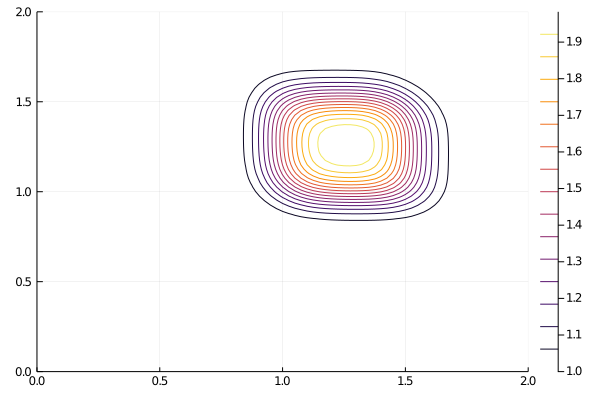

In [7]:
using Plots
#plotly()

u_results = ForLoopMethod()

nx = 81
ny = 81
x = range(0, stop=2, length=nx)
y = range(0, stop=2, length=ny)

p = contour(x,y,u_results)
plot(p)

In [9]:
function MatrixMethod()
    nx = 81
    ny = 81
    nt = 100
    
    c  = 1
    
    Δx = 2 / (nx - 1)
    Δy = 2 / (ny - 1)
    
    σ  = 0.2
    Δt = σ * Δx

    x = range(0, stop=2, length=nx)
    y = range(0, stop=2, length=ny)

    u = ones(ny, nx)

    u[0.5 .≤ y .≤ 1 , 0.5 .≤ x .≤ 1] .= 2

    uⁿ⁺¹ = u # uⁿ⁺¹ points to u
    
    for n in 1:nt + 1
        uⁿ = copy(uⁿ⁺¹)
        
        u[2:end, 2:end] = (uⁿ[2:end, 2:end] - (c * Δt / Δx * (uⁿ[2:end, 2:end] - uⁿ[2:end, 1:end-1])) - 
                                    (c * Δt / Δy * (uⁿ[2:end, 2:end] - uⁿ[1:end-1, 2:end])))
        
        u[1, :]   .= 1 # Dot broadcasting is used to set each value in the matrix slice equall to 1.
        u[end, :] .= 1
        u[:, 1]   .= 1
        u[:, end] .= 1
    end
    
    return u
    
end



MatrixMethod (generic function with 1 method)

In [10]:
@benchmark MatrixMethod()

BenchmarkTools.Trial: 
  memory estimate:  59.45 MiB
  allocs estimate:  2439
  --------------
  minimum time:     17.122 ms (13.55% GC)
  median time:      35.005 ms (17.94% GC)
  mean time:        35.152 ms (16.47% GC)
  maximum time:     54.710 ms (19.57% GC)
  --------------
  samples:          143
  evals/sample:     1

As you can see, the speed decrease and memory usage increase is substantial.

Although the absolute memory usage and execution time are low these speed gains will increase exponentially with the size and complexity of the problem being evaluated. Try running the benchmarks again with nx and ny equall to 1001 and nt = 1000, note this may take a long time to run depending on your hardware.

This behaviour in Julia is unlike languages such as MATLAB where vectorised/array operations are faster than for loop iteration. MATLAB is able to do this due to a series of optimisations. The use of for loops to perform matrix operations and if/else statements to implement boundary conditions are a much better implementation from a computer science persepective. The Julia documentation provides a comprehensive list of [performance tips](https://docs.julialang.org/en/v1/manual/performance-tips/index.html) that can help improve the performance of Julia programs.

In [11]:
function MatrixMethodV2()
    
    nx = 81
    ny = 81
    nt = 100
    
    c  = 1.0
    
    Δx = 2.0 / (nx - 1)
    Δy = 2.0 / (ny - 1)
    
    σ  = 0.2
    Δt = σ * Δx

    x = range(0.0, stop=2.0, length=nx)
    y = range(0.0, stop=2.0, length=ny)

    u₀ = ones(ny, nx)

    u₀[0.5 .≤ y .≤ 1.0 , 0.5 .≤ x .≤ 1.0] .= 2.0

    uⁿ⁺¹ = u₀

    row, col = size(uⁿ⁺¹)
    
    
    temp_u = zeros(row-1,col-1)
    uⁿ = zeros(row,col)  # pre-allocate
    
    for n in 1:nt + 1
        
        uⁿ .= uⁿ⁺¹        
        temp_u = @. (uⁿ[2:end, 2:end] - (c * Δt / Δx * (uⁿ[2:end, 2:end] - uⁿ[2:end, 1:end-1])) - 
                                    (c * Δt / Δy * (uⁿ[2:end, 2:end] - uⁿ[1:end-1, 2:end])))
        uⁿ⁺¹[2:end, 2:end] .= temp_u
        
        
        #uⁿ⁺¹[1,:] .= 1.0
        #uⁿ⁺¹[row,:] .= 1.0
        #uⁿ⁺¹[:,col] = 1.0
        #uⁿ⁺¹[:,1] = 1.0
        
        
    end
    
    return uⁿ⁺¹
    
end

MatrixMethodV2 (generic function with 1 method)

In [12]:
@benchmark MatrixMethodV2()

BenchmarkTools.Trial: 
  memory estimate:  29.79 MiB
  allocs estimate:  1332
  --------------
  minimum time:     10.258 ms (0.00% GC)
  median time:      20.110 ms (10.84% GC)
  mean time:        20.884 ms (13.30% GC)
  maximum time:     37.290 ms (23.75% GC)
  --------------
  samples:          240
  evals/sample:     1

In [13]:
function MatrixMethodV3()
    
    nx = 81
    ny = 81
    nt = 100
    
    c  = 1.0
    
    Δx = 2.0 / (nx - 1)
    Δy = 2.0 / (ny - 1)
    
    σ  = 0.2
    Δt = σ * Δx

    x = range(0.0, stop=2.0, length=nx)
    y = range(0.0, stop=2.0, length=ny)

    u₀ = ones(ny, nx)

    u₀[0.5 .≤ y .≤ 1.0 , 0.5 .≤ x .≤ 1.0] .= 2.0

    uⁿ⁺¹ = u₀

    row, col = size(uⁿ⁺¹)
    
    
    temp_u = zeros(row-1,col-1)  # pre-allocate to speed up
    uⁿ = zeros(row,col)    # pre-allocate
    
    for n in 1:nt + 1 ##loop across number of time steps
           
        uₘ = @view uⁿ⁺¹[2:end, 2:end]
        uₗ = @view uⁿ⁺¹[2:end, 1:end-1]
        uᵤ = @view uⁿ⁺¹[1:end-1, 2:end]
               
        temp_u .= uₘ .- (c*Δt/Δx*(uₘ .- uₗ)) .- (c*Δt/Δy*(uₘ .- uᵤ))
        uₘ .= temp_u
        
        
        #uⁿ⁺¹[1,:] .= 1.0
        #uⁿ⁺¹[row,:] .= 1.0
        #uⁿ⁺¹[:,col] = 1.0
        #uⁿ⁺¹[:,1] = 1.0
        
        
    end
    
    return uⁿ⁺¹
    
end

MatrixMethodV3 (generic function with 1 method)

In [14]:
@benchmark MatrixMethodV3()

BenchmarkTools.Trial: 
  memory estimate:  19.93 MiB
  allocs estimate:  1130
  --------------
  minimum time:     5.878 ms (0.00% GC)
  median time:      10.295 ms (0.00% GC)
  mean time:        12.219 ms (15.46% GC)
  maximum time:     25.065 ms (29.57% GC)
  --------------
  samples:          409
  evals/sample:     1